Dataset Shape: (4566, 6530)
   EEG_channel_1_t1  EEG_channel_1_t2  EEG_channel_1_t3  EEG_channel_1_t4  \
0         -3.457432        -15.610134        -28.209033        -16.500817   
1         12.856846          7.200323          4.795857         13.225275   
2         13.143232          3.307855          8.480391          7.013710   
3         30.523582         28.615215         41.685072         28.333728   
4         -8.910801        -10.594044        -30.384980        -10.884113   

   EEG_channel_1_t5  EEG_channel_1_t6  EEG_channel_1_t7  EEG_channel_1_t8  \
0        -16.546740        -24.126600        -24.409480         -5.469685   
1          3.833067         15.926209         11.693700          9.498457   
2          2.753549         -6.774113          7.940243          2.431553   
3         25.406661         16.704956         18.192949         29.348514   
4         -2.765033         -6.931607         -2.220146         -5.399940   

   EEG_channel_1_t9  EEG_channel_1_t10  ...  E

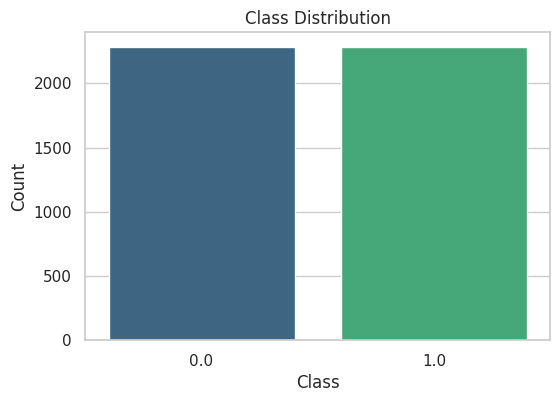

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())
print("Unique subjects:", df['subindex'].unique())
print("Class distribution:")
print(df['substate'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='substate', data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


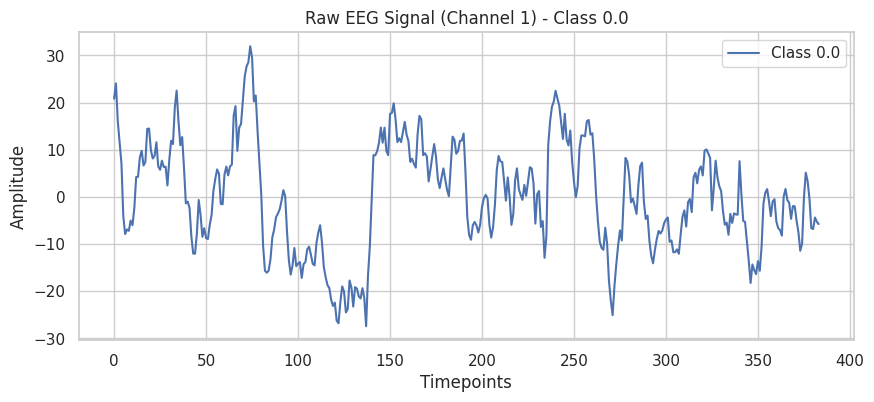

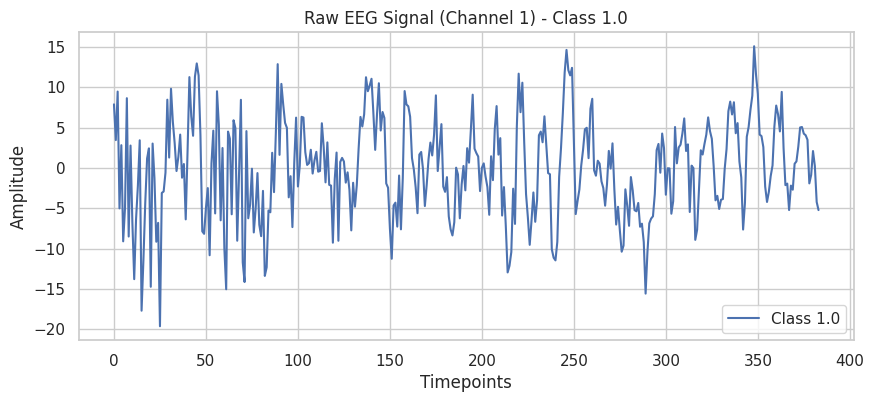

In [31]:
import numpy as np
from sklearn.utils import shuffle

X = df.drop(columns=['subindex', 'substate']).values  
y = df['substate'].values  
X = X.reshape(X.shape[0], 17, 384)
X, y = shuffle(X, y, random_state=42)

unique_classes = np.unique(y)
for label in unique_classes:
    idx = np.where(y == label)[0][0]
    sample = X[idx, 0, :]  # Extract Channel 1
    plt.figure(figsize=(10,4))
    plt.plot(sample, label=f'Class {label}')
    plt.title(f'Raw EEG Signal (Channel 1) - Class {label}')
    plt.xlabel('Timepoints')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()


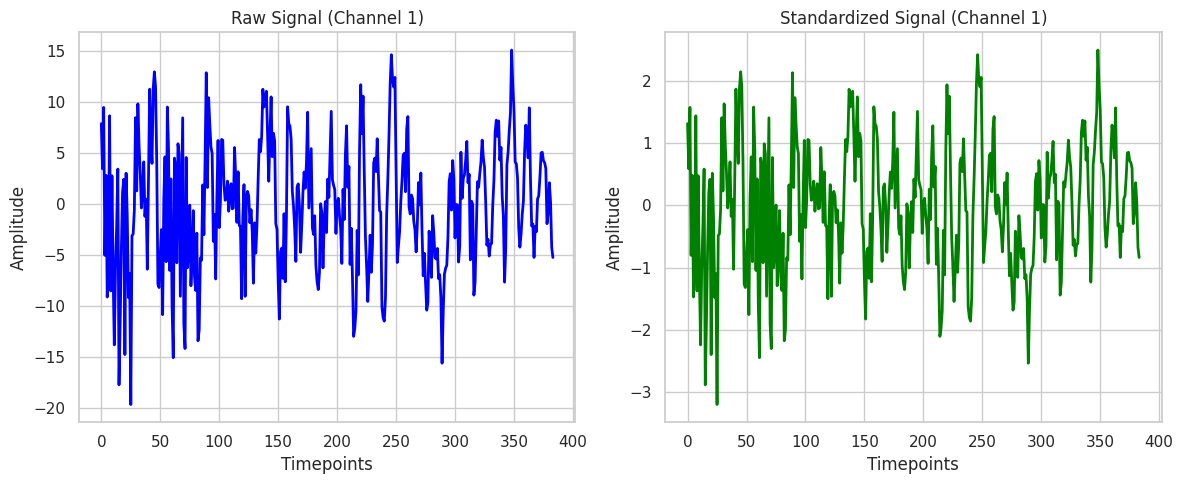

In [32]:
from sklearn.preprocessing import StandardScaler

sample_idx = 0
raw_channel = X[sample_idx, 0, :]
scaler = StandardScaler()
standardized_channel = scaler.fit_transform(raw_channel.reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(raw_channel, color='blue', linewidth=2)
plt.title("Raw Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(standardized_channel, color='green', linewidth=2)
plt.title("Standardized Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


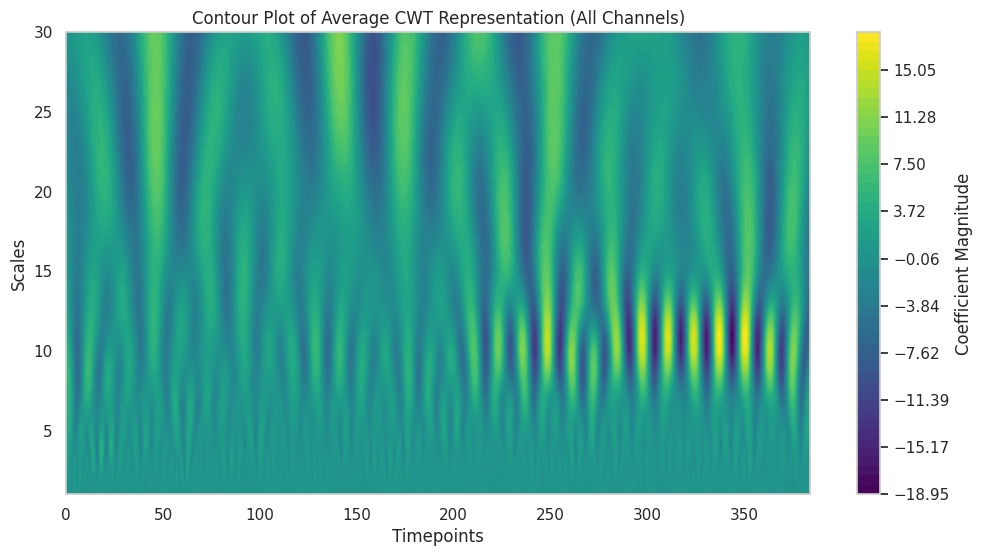

In [33]:
import pywt

def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)
wavelet = 'morl'

sample_for_cwt = X[sample_idx:sample_idx+1]
cwt_output = apply_cwt(sample_for_cwt, scales, wavelet)
cwt_sample = cwt_output[0]
cwt_avg = np.mean(cwt_sample, axis=-1)  # Average over channels

plt.figure(figsize=(12,6))
time = np.linspace(0, 384, 384)
levels = np.linspace(np.min(cwt_avg), np.max(cwt_avg), 50)
contour = plt.contourf(time, scales, cwt_avg, levels=levels, cmap='viridis')
plt.colorbar(contour, label='Coefficient Magnitude')
plt.title("Contour Plot of Average CWT Representation (All Channels)")
plt.xlabel("Timepoints")
plt.ylabel("Scales")
plt.show()


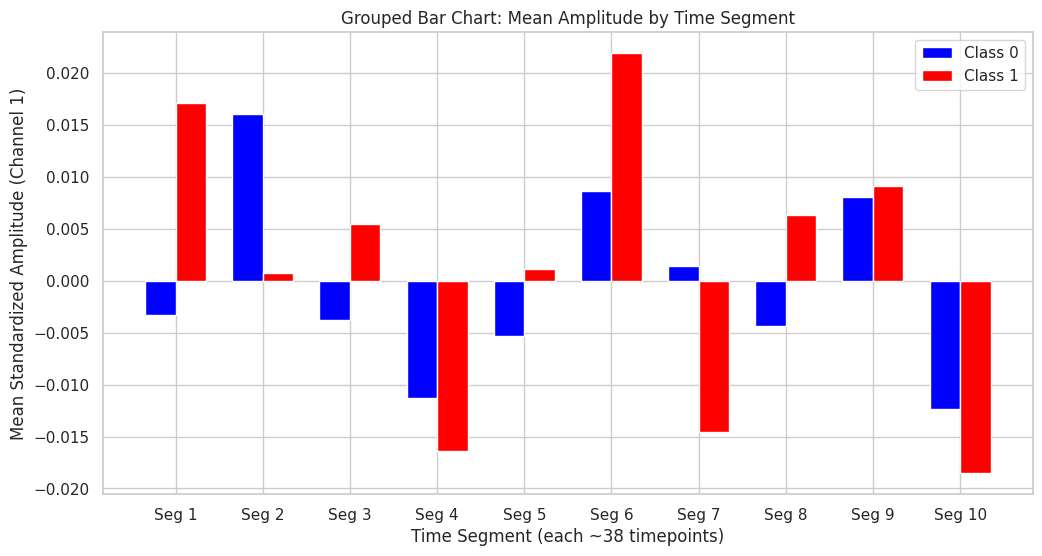

In [34]:
# Standardize the entire dataset channel-wise for visualization
X_std = np.copy(X)
for ch in range(X_std.shape[1]):
    scaler = StandardScaler()
    X_std[:, ch, :] = scaler.fit_transform(X_std[:, ch, :].reshape(-1,1)).reshape(X_std.shape[0], X_std.shape[2])

class0_idx = np.where(y == 0)[0]
class1_idx = np.where(y == 1)[0]

avg_class0 = np.mean(X_std[class0_idx, 0, :], axis=0)
avg_class1 = np.mean(X_std[class1_idx, 0, :], axis=0)

segments = 10
segment_length = 384 // segments
mean_class0_segments = [np.mean(avg_class0[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
mean_class1_segments = [np.mean(avg_class1[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
indices = np.arange(segments)
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(indices - width/2, mean_class0_segments, width, label="Class 0", color="blue")
plt.bar(indices + width/2, mean_class1_segments, width, label="Class 1", color="red")
plt.xlabel(f"Time Segment (each ~{segment_length} timepoints)")
plt.ylabel("Mean Standardized Amplitude (Channel 1)")
plt.title("Grouped Bar Chart: Mean Amplitude by Time Segment")
plt.xticks(indices, [f"Seg {i+1}" for i in indices])
plt.legend()
plt.show()


Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 60s 363ms/step - accuracy: 0.6963 - loss: 1.2566 - val_accuracy: 0.7976 - val_loss: 0.9684 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8691 - loss: 0.8203 - val_accuracy: 0.8917 - val_loss: 0.6928 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8975 - loss: 0.6941 - val_accuracy: 0.9311 - val_loss: 0.5684 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9164 - loss: 0.5923 - val_accuracy: 0.9551 - val_loss: 0.4894 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9110 - loss: 0.5613 - val_accuracy: 0.9453 - val_loss: 0.4455 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9172 - loss: 0.5169 - val_accuracy: 0.9486 - val_loss: 0.4155 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

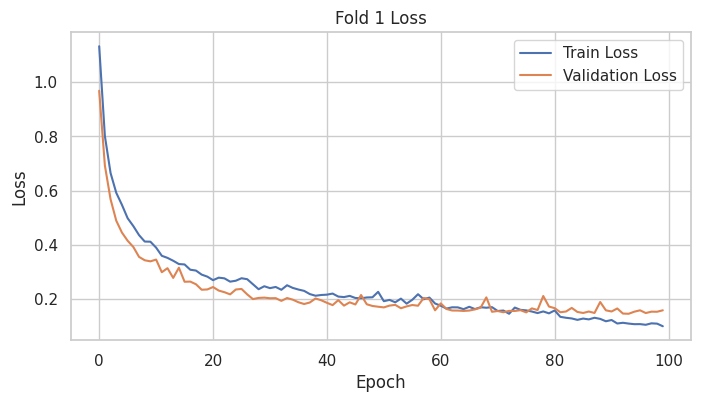

Score for fold 1: Loss = 0.1592 ; Accuracy = 96.39%
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.6864 - loss: 1.3402 - val_accuracy: 0.7985 - val_loss: 1.0287 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8366 - loss: 0.9312 - val_accuracy: 0.8970 - val_loss: 0.7622 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8929 - loss: 0.7329 - val_accuracy: 0.9124 - val_loss: 0.6468 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9115 - loss: 0.6252 - val_accuracy: 0.9376 - val_loss: 0.5346 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9213 - loss: 0.5754 - val_accuracy: 0.9496 - val_loss: 0.4968 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9260 - loss: 0.5079 - val_accuracy: 0.9474 - val_loss: 0.4590 - learning_rate:

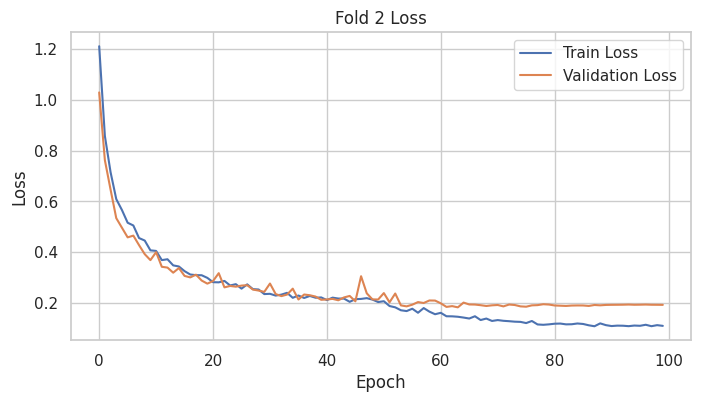

Score for fold 2: Loss = 0.1937 ; Accuracy = 96.17%
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.7002 - loss: 1.2862 - val_accuracy: 0.7886 - val_loss: 1.0041 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8692 - loss: 0.8425 - val_accuracy: 0.9102 - val_loss: 0.7013 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9082 - loss: 0.6753 - val_accuracy: 0.9288 - val_loss: 0.6009 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8990 - loss: 0.6320 - val_accuracy: 0.9365 - val_loss: 0.5255 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9178 - loss: 0.5571 - val_accuracy: 0.9365 - val_loss: 0.5032 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9147 - loss: 0.5323 - val_accuracy: 0.9266 - val_loss: 0.4961 - learning_rate:

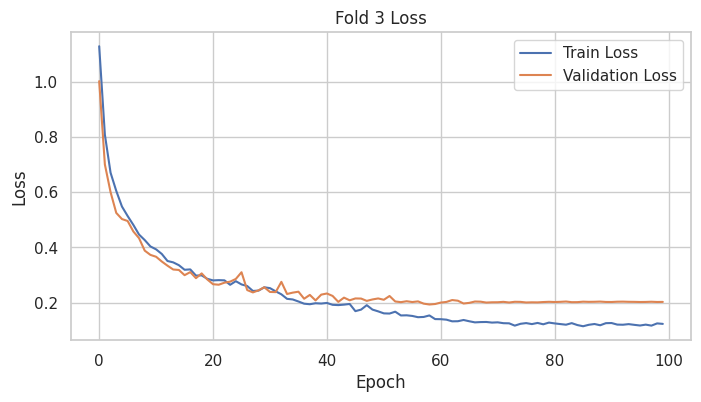

Score for fold 3: Loss = 0.2022 ; Accuracy = 95.18%
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - accuracy: 0.7058 - loss: 1.2505 - val_accuracy: 0.8215 - val_loss: 1.3102 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8692 - loss: 0.8453 - val_accuracy: 0.9080 - val_loss: 0.9741 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9003 - loss: 0.6944 - val_accuracy: 0.9343 - val_loss: 0.7425 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9062 - loss: 0.6350 - val_accuracy: 0.9332 - val_loss: 0.7910 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9239 - loss: 0.5499 - val_accuracy: 0.9310 - val_loss: 0.8261 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.9166 - loss: 0.5149 - val_accuracy: 0.9430 - val_loss: 0.7729 - learning_rate:

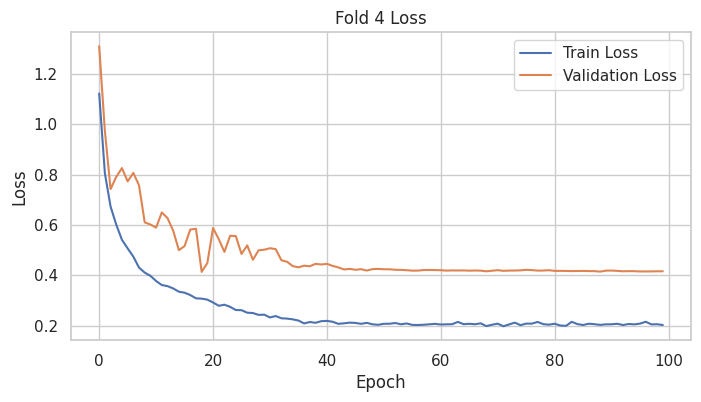

Score for fold 4: Loss = 0.4157 ; Accuracy = 95.84%
Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.6999 - loss: 1.2812 - val_accuracy: 0.8423 - val_loss: 0.9384 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.8509 - loss: 0.8743 - val_accuracy: 0.8598 - val_loss: 0.7632 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.8919 - loss: 0.7125 - val_accuracy: 0.9244 - val_loss: 0.5838 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9151 - loss: 0.6120 - val_accuracy: 0.9255 - val_loss: 0.5415 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9179 - loss: 0.5378 - val_accuracy: 0.9036 - val_loss: 0.5334 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9292 - loss: 0.5044 - val_accuracy: 0.9419 - val_loss: 0.4375 - learning_rate:

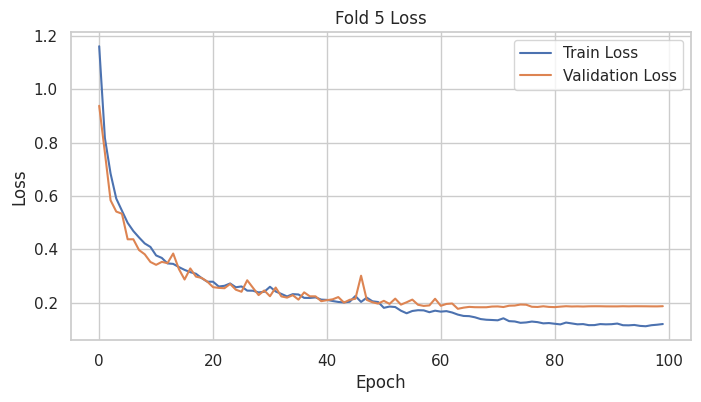

Score for fold 5: Loss = 0.1865 ; Accuracy = 95.95%

--- Average scores for all folds ---
Accuracy: 95.90% (+- 0.41%)
Loss: 0.2315


In [35]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1,1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    return layers.Add()([inputs, attn_features])

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)
    branch2 = layers.Conv2D(filters, kernel_size=(5,5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)
    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1,1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    return layers.Add()([inputs, fused])

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5,5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7,7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)
    reduced = layers.Conv2D(filters, kernel_size=(1,1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)
    att_map = layers.Conv2D(filters, kernel_size=(1,1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])
    residual = layers.Conv2D(filters, kernel_size=(1,1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    return layers.Activation('relu')(out)

def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape
    in_len = len(in_sh)
    expanded_axis = 2
    if attention_model == 'mha':
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam':
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))
    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    x = layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = temporal_frequency_attention_2d(x, 64)
    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])
    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)
    x = layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    X_train_fold, y_train_fold = shuffle(X_train_fold, y_train_fold, random_state=42)
    X_val_fold, y_val_fold = shuffle(X_val_fold, y_val_fold, random_state=42)
    X_train_fold, X_val_fold = standardize_raw_data(X_train_fold, X_val_fold)
    X_train_fold_cwt = apply_cwt(X_train_fold, scales, wavelet)
    X_val_fold_cwt = apply_cwt(X_val_fold, scales, wavelet)
    model_cv = build_model((30,384,17))
    reduce_lr_cv = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history_cv = model_cv.fit(X_train_fold_cwt, y_train_fold, epochs=100, batch_size=32,
                              validation_data=(X_val_fold_cwt, y_val_fold),
                              callbacks=[reduce_lr_cv],
                              verbose=1)
    plt.figure(figsize=(8,4))
    plt.plot(history_cv.history['loss'], label='Train Loss')
    plt.plot(history_cv.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    scores = model_cv.evaluate(X_val_fold_cwt, y_val_fold, verbose=0)
    print(f"Score for fold {fold_no}: Loss = {scores[0]:.4f} ; Accuracy = {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])
    fold_no += 1

print("\n--- Average scores for all folds ---")
print(f"Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)")
print(f"Loss: {np.mean(loss_per_fold):.4f}")


In [2]:
"""
Copyright (C) 2022 King Saud University, Saudi Arabia 
SPDX-License-Identifier: Apache-2.0 

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the 
License at

http://www.apache.org/licenses/LICENSE-2.0  

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR 
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License. 

Author:  Hamdi Altaheri
"""

import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

###############################################
# Additional Attention Blocks
###############################################

def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True): 
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion
    
    if attention_model == 'mha':   # Multi-head self attention layer 
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer 
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))
        
    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    # Use GlobalMaxPooling2D instead of reducing on the channel axis.
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################

def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)

print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# 2. Prepare Raw EEG Data
###############################################
X = df.drop(columns=['subindex', 'substate']).values  
y = df['substate'].values  
X = X.reshape(X.shape[0], 17, 384)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
X_train, X_test = standardize_raw_data(X_train, X_test)

###############################################
# 3. Continuous Wavelet Transform Preprocessing
###############################################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

print("Transformed training data shape:", X_train_cwt.shape)
print("Transformed test data shape:", X_test_cwt.shape)

###############################################
# 4. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)
    
    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)
    
    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)
    
    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)
    
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])
    
    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 5. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = temporal_frequency_attention_2d(x, 64)
    
    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])
    
    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])
    
    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)
    
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((30, 384, 17))
model.summary()

###############################################
# 6. Train the Model
###############################################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test),
                    callbacks=[reduce_lr])

###############################################
# 7. Evaluate the Model
###############################################
y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)


Dataset Shape: (4566, 6530)

First 5 rows:
   EEG_channel_1_t1  EEG_channel_1_t2  EEG_channel_1_t3  EEG_channel_1_t4  \
0         -3.457432        -15.610134        -28.209033        -16.500817   
1         12.856846          7.200323          4.795857         13.225275   
2         13.143232          3.307855          8.480391          7.013710   
3         30.523582         28.615215         41.685072         28.333728   
4         -8.910801        -10.594044        -30.384980        -10.884113   

   EEG_channel_1_t5  EEG_channel_1_t6  EEG_channel_1_t7  EEG_channel_1_t8  \
0        -16.546740        -24.126600        -24.409480         -5.469685   
1          3.833067         15.926209         11.693700          9.498457   
2          2.753549         -6.774113          7.940243          2.431553   
3         25.406661         16.704956         18.192949         29.348514   
4         -2.765033         -6.931607         -2.220146         -5.399940   

   EEG_channel_1_t9  EEG_channe

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_1          │ (None, 30, 384, 17)    │              0 │ input_layer_1[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 30, 384, 64)    │            256 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_4       │ (None, 30, 384, 64)    │              0 │ batch_normalization_6… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_4[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 15, 192, 64)    │          4,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 15, 192, 64)    │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 15, 192, 64)    │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 15, 192, 64)    │         36,928 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 15, 192, 64)    │        102,464 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 15, 192, 64)    │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 15, 192, 64)    │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_5       │ (None, 15, 192, 64)    │              0 │ batch_normalization_7… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_6  

 Total params: 616,747 (2.35 MB)

 Trainable params: 615,467 (2.35 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 418ms/step - accuracy: 0.6857 - loss: 1.2923 - val_accuracy: 0.8370 - val_loss: 0.9784 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.8586 - loss: 0.8898 - val_accuracy: 0.8917 - val_loss: 0.7148 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.8952 - loss: 0.7324 - val_accuracy: 0.9398 - val_loss: 0.5693 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9119 - loss: 0.6201 - val_accuracy: 0.9223 - val_loss: 0.5471 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9164 - loss: 0.5767 - val_accuracy: 0.9256 - val_loss: 0.5031 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9250 - loss: 0.5178 - val_accuracy: 0.9201 - val_loss: 0.4917 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

In [4]:
test_loss, test_accuracy = model.evaluate(X_test_cwt, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Test Loss: 0.17852194607257843
Test Accuracy: 0.9617067575454712


Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_

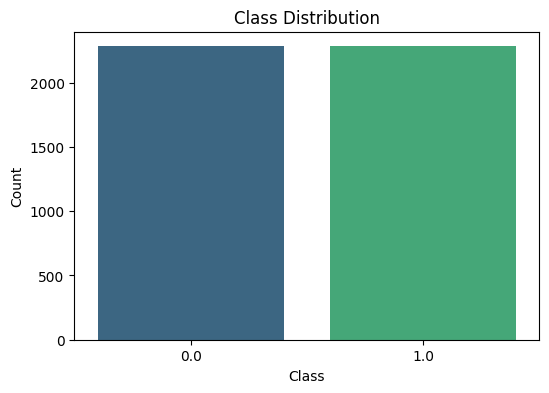

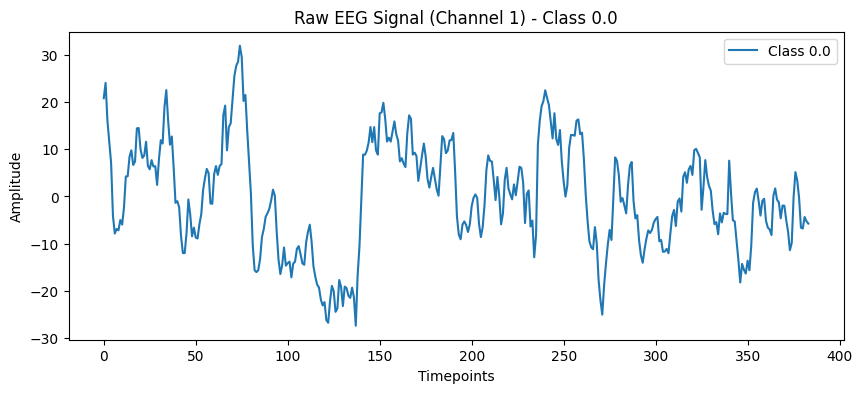

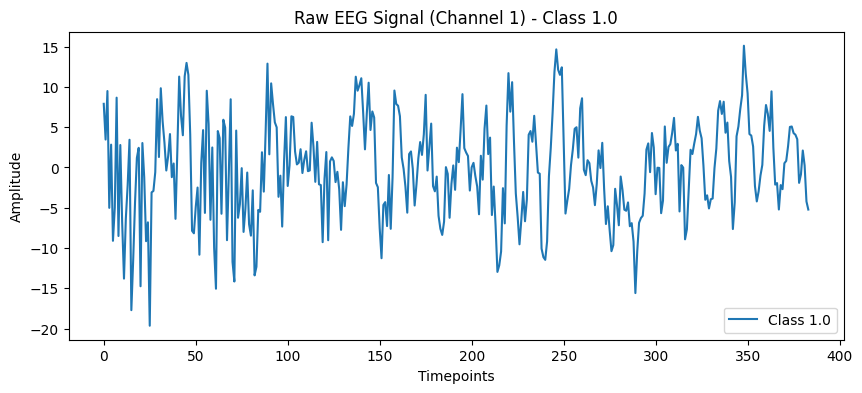

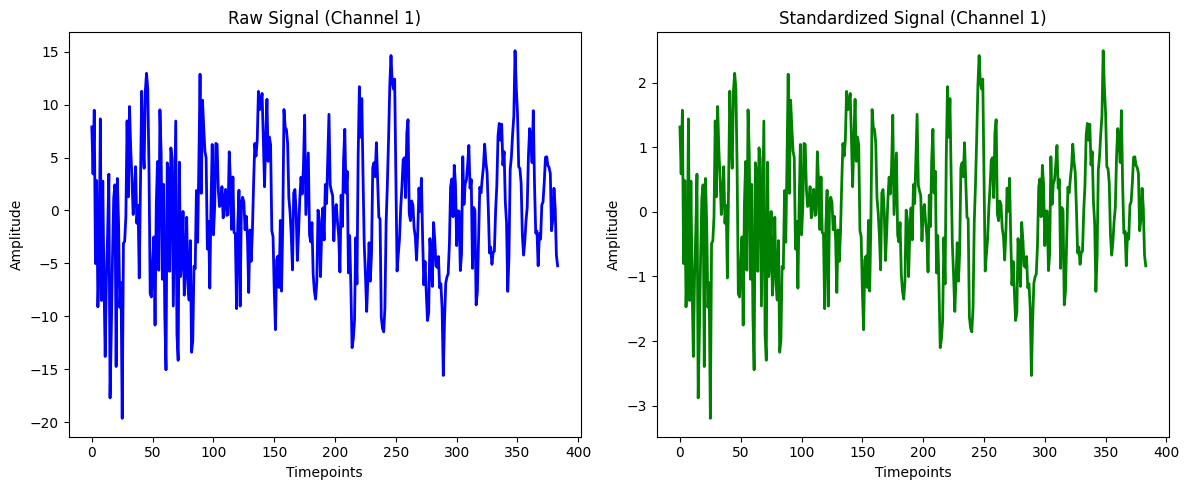

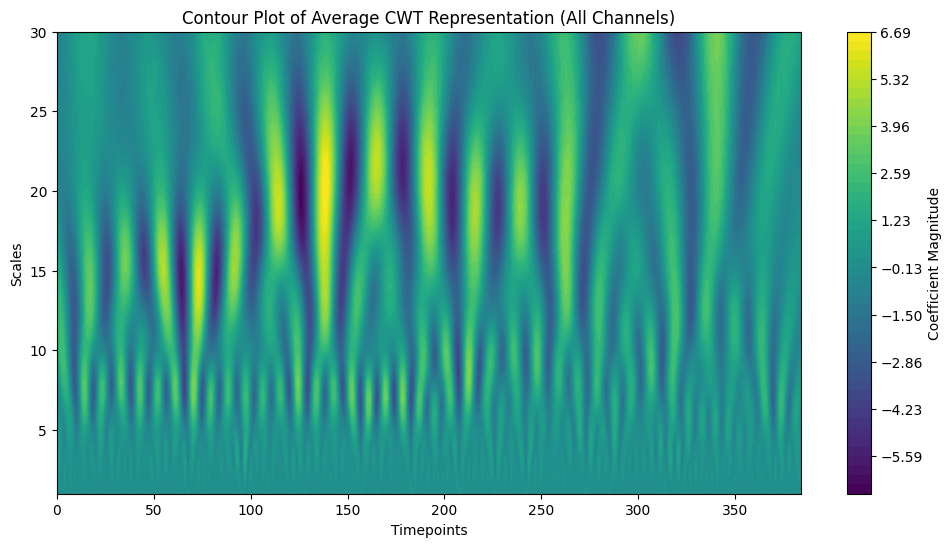

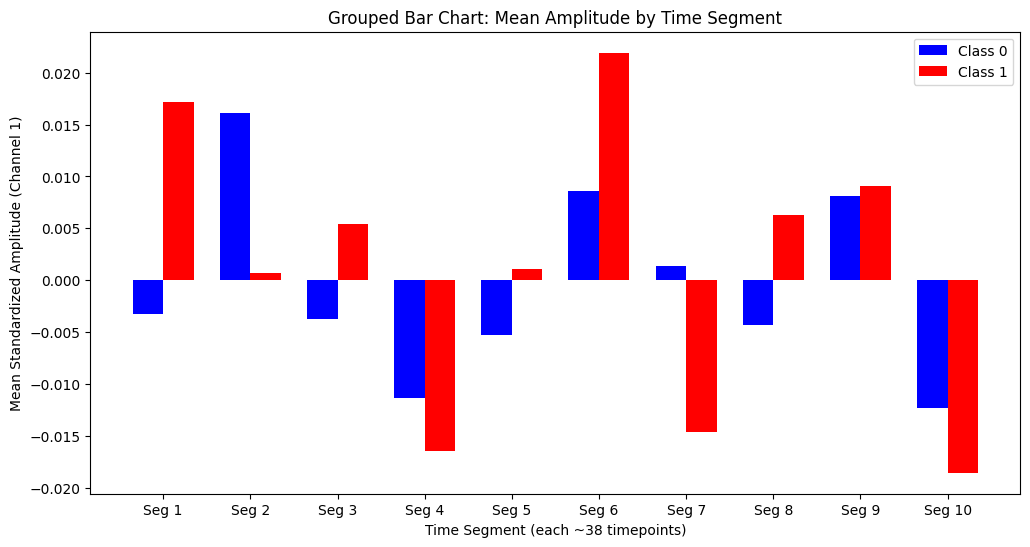


--- Training for fold 1 ---
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.7199 - loss: 1.2621 - val_accuracy: 0.7732 - val_loss: 1.0664 - learning_rate: 5.0000e-04
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8399 - loss: 0.9403 - val_accuracy: 0.7986 - val_loss: 0.8949 - learning_rate: 5.0000e-04
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.8814 - loss: 0.7444 - val_accuracy: 0.9273 - val_loss: 0.6093 - learning_rate: 5.0000e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.8954 - loss: 0.6631 - val_accuracy: 0.9352 - val_loss: 0.5340 - learning_rate: 5.0000e-04
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9206 - loss: 0.5746 - val_accuracy: 0.9501 - val_loss: 0.4749 - learning_rate: 5.0000e-04
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.9252 - loss: 0.5254 - val_accuracy: 0.9317 - val_loss: 0.4779 - learning_rate: 5.0000e-04
Epoch 7/50
107/10

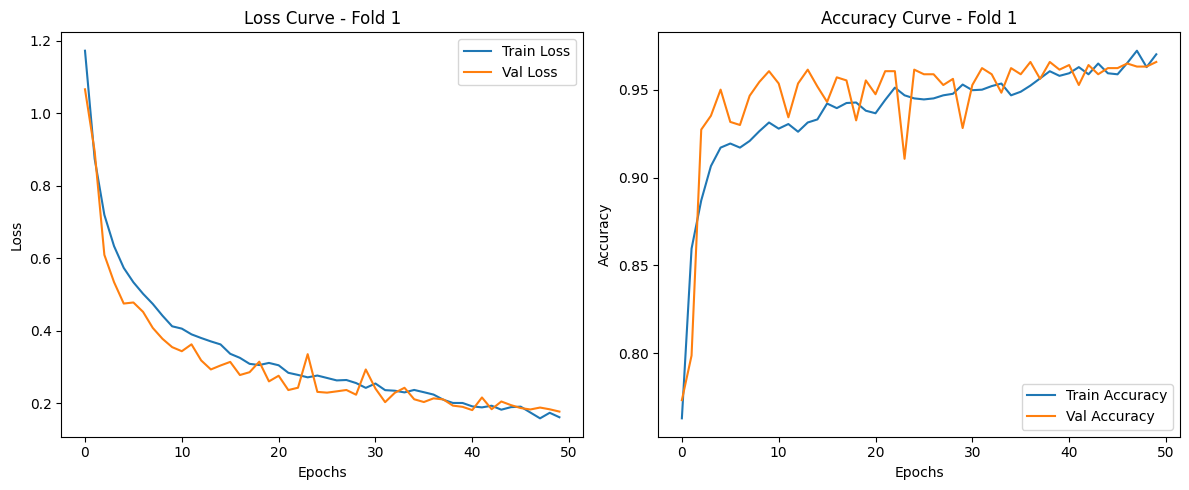

Score for fold 1: Loss = 0.1766 ; Accuracy = 96.58%
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step


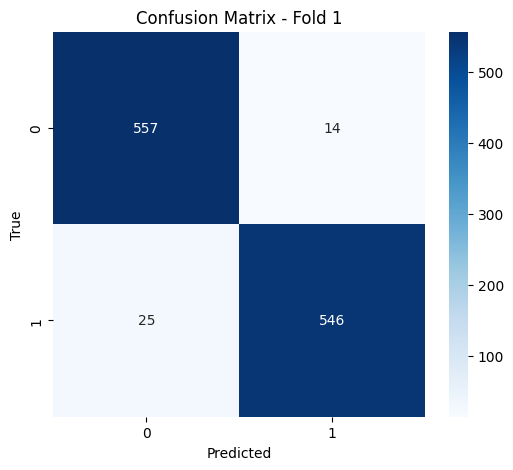

Classification Report for fold 1:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       571
         1.0       0.97      0.96      0.97       571

    accuracy                           0.97      1142
   macro avg       0.97      0.97      0.97      1142
weighted avg       0.97      0.97      0.97      1142


--- Training for fold 2 ---
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.6609 - loss: 1.3626 - val_accuracy: 0.7855 - val_loss: 1.0469 - learning_rate: 5.0000e-04
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.8575 - loss: 0.9027 - val_accuracy: 0.8993 - val_loss: 0.7321 - learning_rate: 5.0000e-04
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - accuracy: 0.8858 - loss: 0.7462 - val_accuracy: 0.9273 - val_loss: 0.6101 - learning_rate: 5.0000e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9101 - loss: 0.6174 - val_accuracy: 0.9282 - val_loss: 0.5570 -

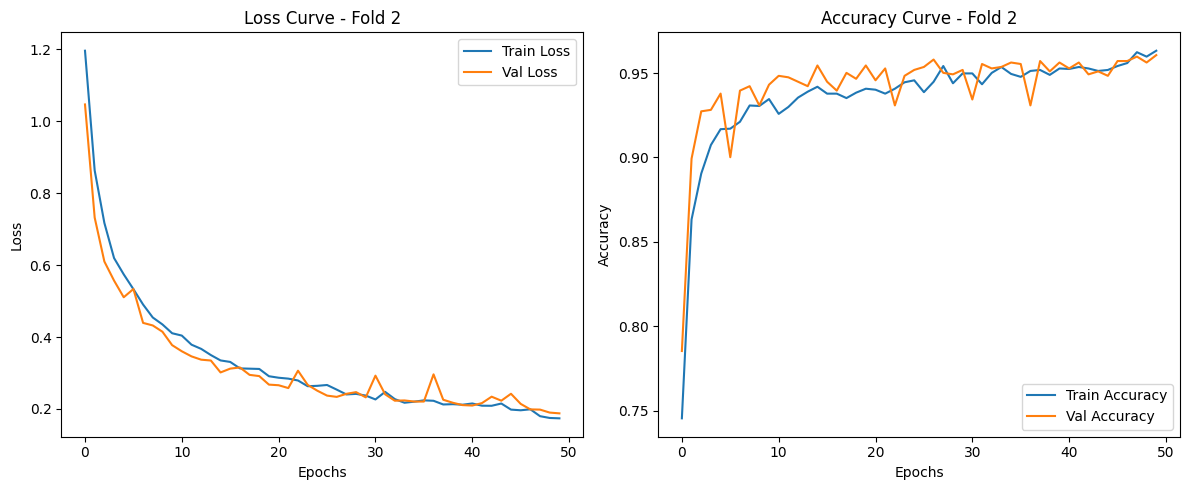

Score for fold 2: Loss = 0.1877 ; Accuracy = 96.06%
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


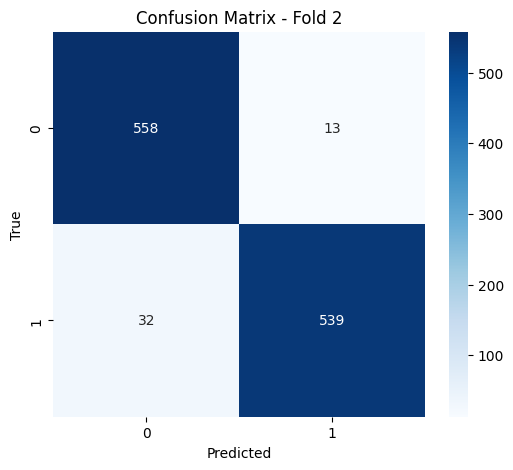

Classification Report for fold 2:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       571
         1.0       0.98      0.94      0.96       571

    accuracy                           0.96      1142
   macro avg       0.96      0.96      0.96      1142
weighted avg       0.96      0.96      0.96      1142


--- Training for fold 3 ---
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.6787 - loss: 1.3593 - val_accuracy: 0.7336 - val_loss: 1.4201 - learning_rate: 5.0000e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.8484 - loss: 0.9287 - val_accuracy: 0.8896 - val_loss: 0.9686 - learning_rate: 5.0000e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.8835 - loss: 0.7757 - val_accuracy: 0.9132 - val_loss: 0.9286 - learning_rate: 5.0000e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.9077 - loss: 0.6751 - val_accuracy: 0.9062 - val_loss: 0.8239 -

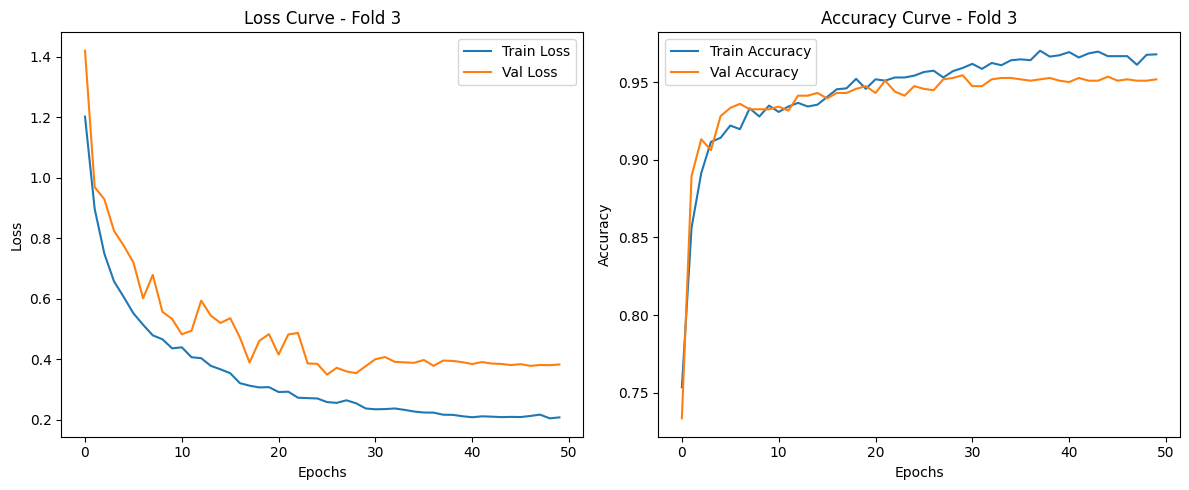

Score for fold 3: Loss = 0.3820 ; Accuracy = 95.18%
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step


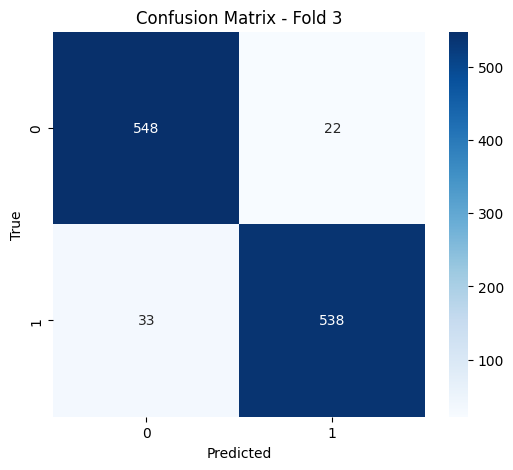

Classification Report for fold 3:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       570
         1.0       0.96      0.94      0.95       571

    accuracy                           0.95      1141
   macro avg       0.95      0.95      0.95      1141
weighted avg       0.95      0.95      0.95      1141


--- Training for fold 4 ---
Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.6807 - loss: 1.3009 - val_accuracy: 0.7493 - val_loss: 1.0555 - learning_rate: 5.0000e-04
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.8511 - loss: 0.9052 - val_accuracy: 0.8712 - val_loss: 0.7634 - learning_rate: 5.0000e-04
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.8869 - loss: 0.7285 - val_accuracy: 0.9027 - val_loss: 0.6496 - learning_rate: 5.0000e-04
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9073 - loss: 0.6433 - val_accuracy: 0.9176 - val_loss: 0.5778 -

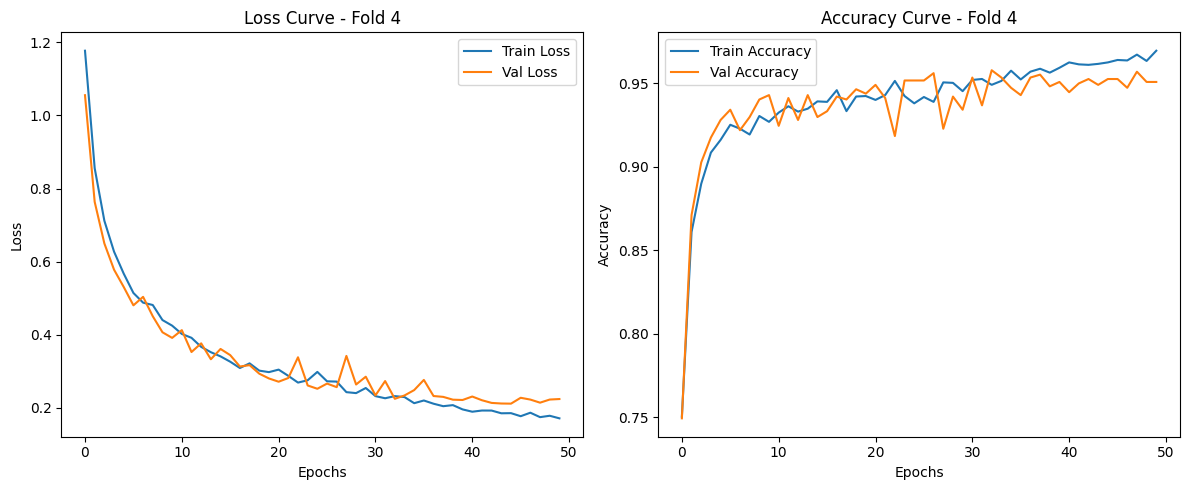

Score for fold 4: Loss = 0.2237 ; Accuracy = 95.09%
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


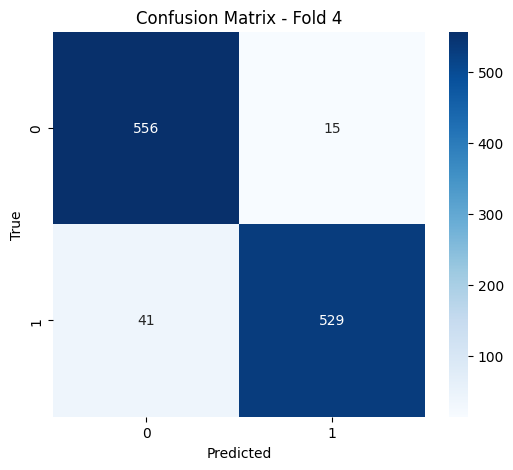

Classification Report for fold 4:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       571
         1.0       0.97      0.93      0.95       570

    accuracy                           0.95      1141
   macro avg       0.95      0.95      0.95      1141
weighted avg       0.95      0.95      0.95      1141


--- Average scores for all folds ---
> Accuracy: 95.73% (+- 0.62%)
> Loss: 0.2425


In [1]:
import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

###############################################
# Additional Attention Blocks
###############################################
def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################
def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

def apply_cwt(X, scales, wavelet):
    # X shape: (n_samples, channels, timepoints)
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
        transformed.append(sample_cwt)
    return np.array(transformed)

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# Visualization: Class Distribution
###############################################
plt.figure(figsize=(6,4))
sns.countplot(x='substate', data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

###############################################
# 2. Prepare Raw EEG Data and Initial Visualizations
###############################################
X = df.drop(columns=['subindex', 'substate']).values  
y = df['substate'].values  
X = X.reshape(X.shape[0], 17, 384)
X, y = shuffle(X, y, random_state=42)

# Plot raw EEG signal for Channel 1 for one sample from each class
unique_classes = np.unique(y)
for label in unique_classes:
    idx = np.where(y == label)[0][0]
    sample = X[idx, 0, :]  # Extract Channel 1
    plt.figure(figsize=(10,4))
    plt.plot(sample, label=f'Class {label}')
    plt.title(f'Raw EEG Signal (Channel 1) - Class {label}')
    plt.xlabel('Timepoints')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot raw vs standardized signal for a sample channel (Channel 1)
sample_idx = 0
raw_channel = X[sample_idx, 0, :]
scaler = StandardScaler()
standardized_channel = scaler.fit_transform(raw_channel.reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(raw_channel, color='blue', linewidth=2)
plt.title("Raw Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(standardized_channel, color='green', linewidth=2)
plt.title("Standardized Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

###############################################
# 3. Continuous Wavelet Transform (CWT) Visualization
###############################################
scales = np.arange(1, 31)
wavelet = 'morl'

# For visualization, compute the average CWT representation over a subset of samples and channels
cwt_list = []
num_samples_vis = min(10, X.shape[0])
for i in range(num_samples_vis):
    sample_cwt = []
    for ch in range(X.shape[1]):
        coeffs, _ = pywt.cwt(X[i, ch, :], scales, wavelet)
        sample_cwt.append(coeffs)
    sample_cwt = np.stack(sample_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
    cwt_list.append(np.mean(sample_cwt, axis=-1))  # average over channels
cwt_avg = np.mean(np.array(cwt_list), axis=0)

plt.figure(figsize=(12,6))
time = np.linspace(0, 384, 384)
levels = np.linspace(np.min(cwt_avg), np.max(cwt_avg), 50)
contour = plt.contourf(time, scales, cwt_avg, levels=levels, cmap='viridis')
plt.colorbar(contour, label='Coefficient Magnitude')
plt.title("Contour Plot of Average CWT Representation (All Channels)")
plt.xlabel("Timepoints")
plt.ylabel("Scales")
plt.show()

###############################################
# 4. Grouped Bar Chart: Mean Amplitude by Time Segment for Channel 1
###############################################
# Standardize the entire dataset channel-wise for visualization
X_std = np.copy(X)
for ch in range(X_std.shape[1]):
    scaler = StandardScaler()
    X_std[:, ch, :] = scaler.fit_transform(X_std[:, ch, :].reshape(-1,1)).reshape(X_std.shape[0], X_std.shape[2])

class0_idx = np.where(y == 0)[0]
class1_idx = np.where(y == 1)[0]

avg_class0 = np.mean(X_std[class0_idx, 0, :], axis=0)
avg_class1 = np.mean(X_std[class1_idx, 0, :], axis=0)

segments = 10
segment_length = 384 // segments
mean_class0_segments = [np.mean(avg_class0[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
mean_class1_segments = [np.mean(avg_class1[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
indices = np.arange(segments)
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(indices - width/2, mean_class0_segments, width, label="Class 0", color="blue")
plt.bar(indices + width/2, mean_class1_segments, width, label="Class 1", color="red")
plt.xlabel(f"Time Segment (each ~{segment_length} timepoints)")
plt.ylabel("Mean Standardized Amplitude (Channel 1)")
plt.title("Grouped Bar Chart: Mean Amplitude by Time Segment")
plt.xticks(indices, [f"Seg {i+1}" for i in indices])
plt.legend()
plt.show()

###############################################
# 5. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 6. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = temporal_frequency_attention_2d(x, 64)

    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

###############################################
# 7. K-Fold Cross Validation Training with Visualization of Loss/Accuracy Curves and Confusion Matrix
###############################################
num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train_index, val_index in skf.split(X, y):
    print(f"\n--- Training for fold {fold_no} ---")

    # Split data for this fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Shuffle and standardize
    X_train_fold, y_train_fold = shuffle(X_train_fold, y_train_fold, random_state=42)
    X_val_fold, y_val_fold = shuffle(X_val_fold, y_val_fold, random_state=42)
    X_train_fold, X_val_fold = standardize_raw_data(X_train_fold, X_val_fold)

    # Apply CWT transformation for this fold:
    # Each sample is transformed to shape (len(scales), 384, 17)
    X_train_fold_cwt = np.array([apply_cwt(sample[np.newaxis, :, :], scales, wavelet)[0] for sample in X_train_fold])
    X_val_fold_cwt = np.array([apply_cwt(sample[np.newaxis, :, :], scales, wavelet)[0] for sample in X_val_fold])

    # Build and train the model for this fold
    model_cv = build_model((len(scales), 384, 17))
    reduce_lr_cv = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    history_cv = model_cv.fit(X_train_fold_cwt, y_train_fold, epochs=50, batch_size=32,
                              validation_data=(X_val_fold_cwt, y_val_fold),
                              callbacks=[reduce_lr_cv],
                              verbose=1)

    # Plot Loss and Accuracy Curves for this fold
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history_cv.history['loss'], label='Train Loss')
    plt.plot(history_cv.history['val_loss'], label='Val Loss')
    plt.title(f'Loss Curve - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_cv.history['accuracy'], label='Train Accuracy')
    plt.plot(history_cv.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy Curve - Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluate the model on the validation fold
    scores = model_cv.evaluate(X_val_fold_cwt, y_val_fold, verbose=0)
    print(f"Score for fold {fold_no}: Loss = {scores[0]:.4f} ; Accuracy = {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Generate predictions and plot confusion matrix for this fold
    y_pred = (model_cv.predict(X_val_fold_cwt) > 0.5).astype(int)
    cm = confusion_matrix(y_val_fold, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold_no}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(f"Classification Report for fold {fold_no}:\n", classification_report(y_val_fold, y_pred))

    fold_no += 1

print("\n--- Average scores for all folds ---")
print(f"> Accuracy: {np.mean(acc_per_fold):.2f}% (+- {np.std(acc_per_fold):.2f}%)")
print(f"> Loss: {np.mean(loss_per_fold):.4f}")


Dataset Shape: (4566, 6530)

First 5 rows:
   EEG_channel_1_t1  EEG_channel_1_t2  EEG_channel_1_t3  EEG_channel_1_t4  \
0         -3.457432        -15.610134        -28.209033        -16.500817   
1         12.856846          7.200323          4.795857         13.225275   
2         13.143232          3.307855          8.480391          7.013710   
3         30.523582         28.615215         41.685072         28.333728   
4         -8.910801        -10.594044        -30.384980        -10.884113   

   EEG_channel_1_t5  EEG_channel_1_t6  EEG_channel_1_t7  EEG_channel_1_t8  \
0        -16.546740        -24.126600        -24.409480         -5.469685   
1          3.833067         15.926209         11.693700          9.498457   
2          2.753549         -6.774113          7.940243          2.431553   
3         25.406661         16.704956         18.192949         29.348514   
4         -2.765033         -6.931607         -2.220146         -5.399940   

   EEG_channel_1_t9  EEG_channe

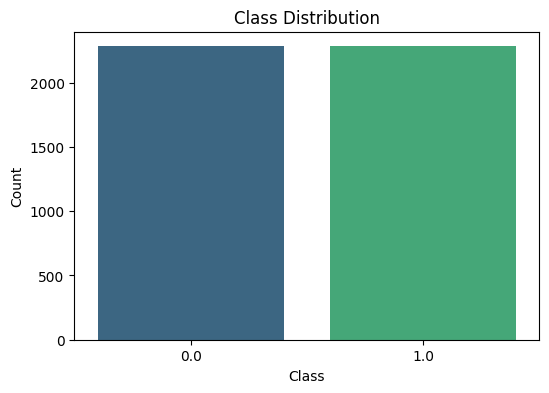

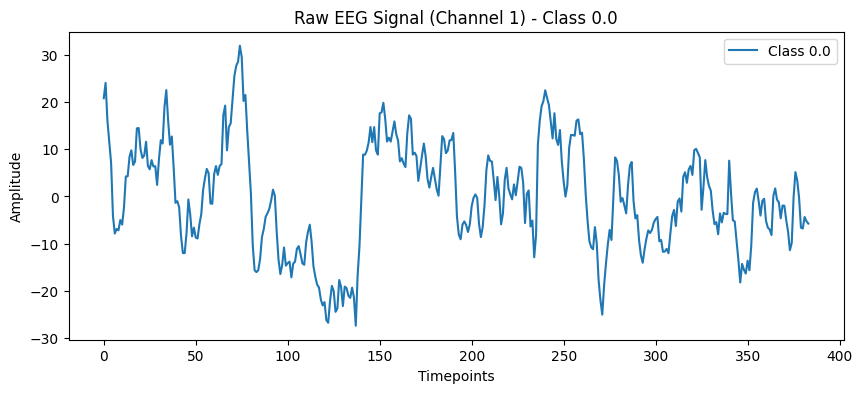

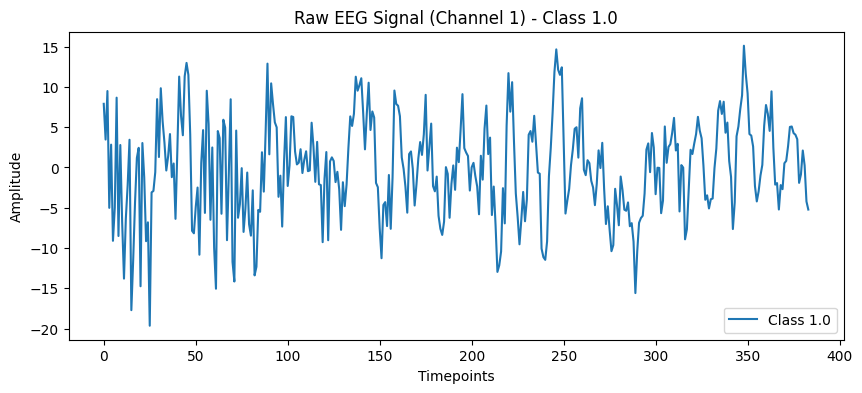

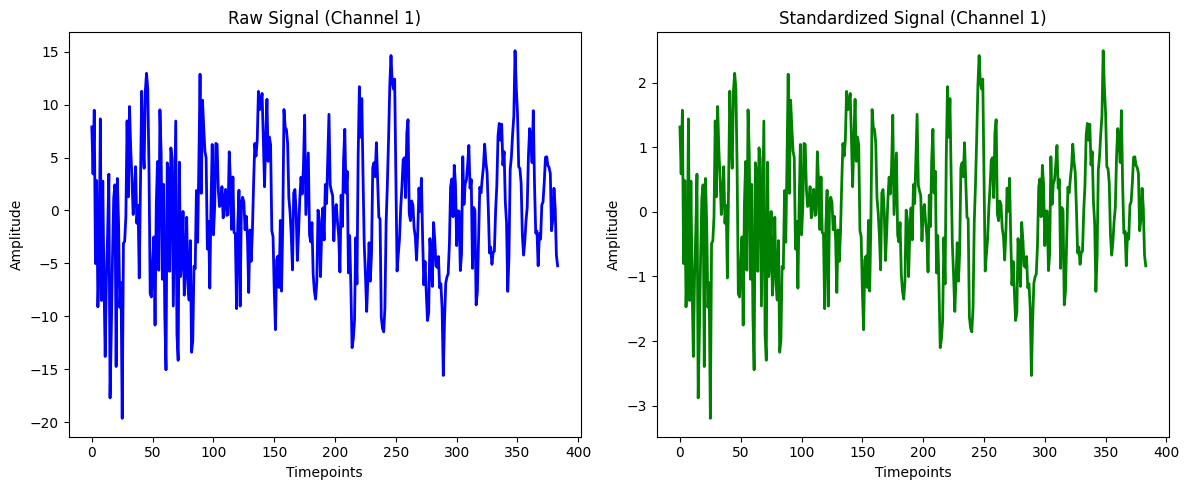

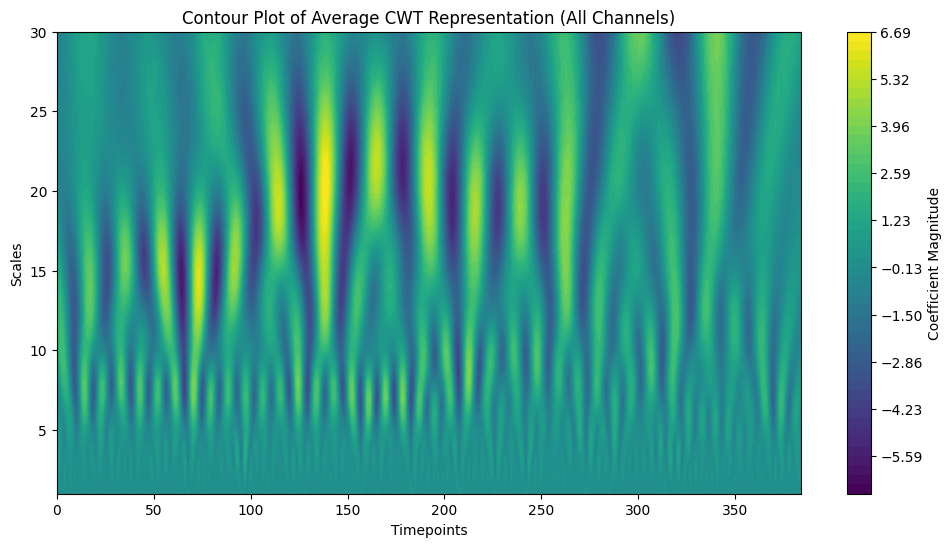

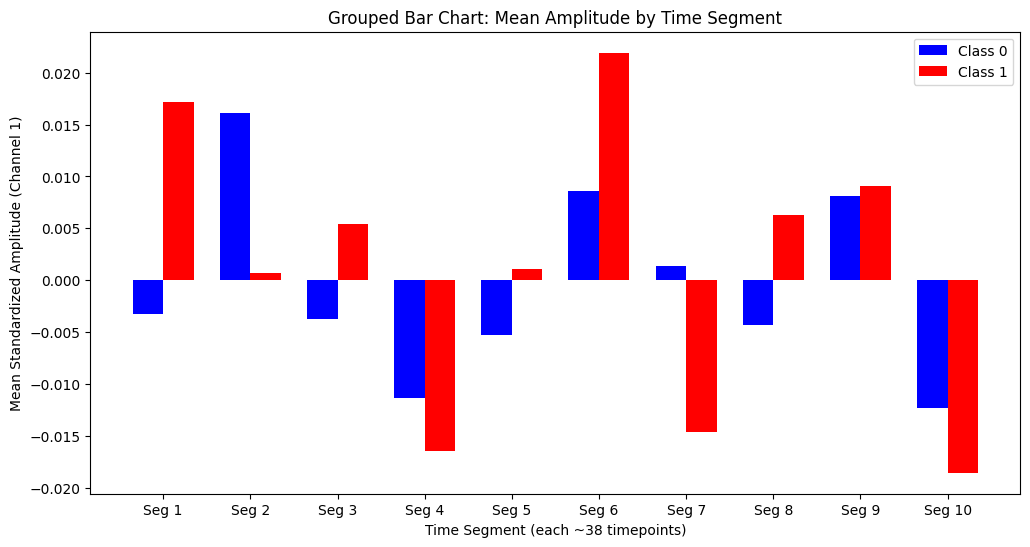

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 386ms/step - accuracy: 0.7088 - loss: 1.2968 - val_accuracy: 0.7309 - val_loss: 1.0675 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.8703 - loss: 0.8644 - val_accuracy: 0.8545 - val_loss: 0.7986 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9057 - loss: 0.6969 - val_accuracy: 0.8818 - val_loss: 0.6826 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.9011 - loss: 0.6451 - val_accuracy: 0.9168 - val_loss: 0.5604 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9234 - loss: 0.5539 - val_accuracy: 0.8807 - val_loss: 0.5998 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.9181 - loss: 0.5107 - val_accuracy: 0.9114 - val_loss: 0.5127 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

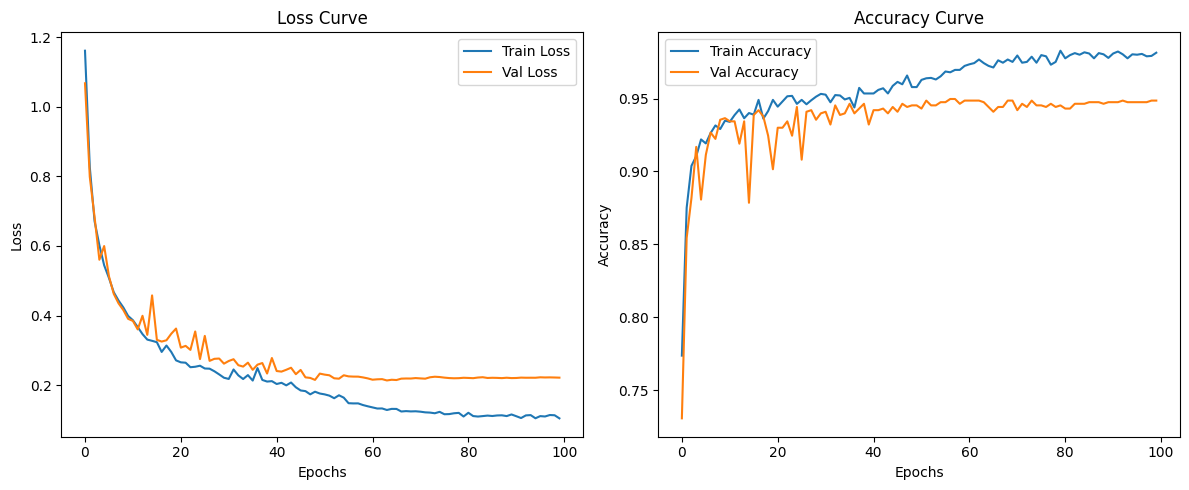

Final Score: Loss = 0.2216 ; Accuracy = 94.86%
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step


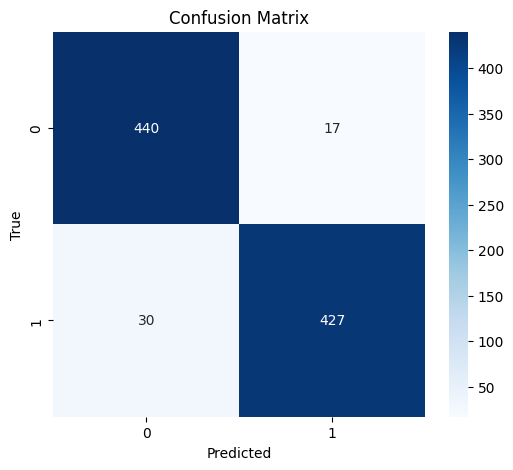

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       457
         1.0       0.96      0.93      0.95       457

    accuracy                           0.95       914
   macro avg       0.95      0.95      0.95       914
weighted avg       0.95      0.95      0.95       914



In [1]:
import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

###############################################
# Additional Attention Blocks
###############################################
def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################
def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

def apply_cwt(X, scales, wavelet):
    # X shape: (n_samples, channels, timepoints)
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
        transformed.append(sample_cwt)
    return np.array(transformed)

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)

print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# Visualization: Class Distribution
###############################################
plt.figure(figsize=(6,4))
sns.countplot(x='substate', data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

###############################################
# 2. Prepare Raw EEG Data and Initial Visualizations
###############################################
X = df.drop(columns=['subindex', 'substate']).values  
y = df['substate'].values  
X = X.reshape(X.shape[0], 17, 384)
X, y = shuffle(X, y, random_state=42)

# Plot raw EEG signal for Channel 1 for one sample from each class
unique_classes = np.unique(y)
for label in unique_classes:
    idx = np.where(y == label)[0][0]
    sample = X[idx, 0, :]  # Extract Channel 1
    plt.figure(figsize=(10,4))
    plt.plot(sample, label=f'Class {label}')
    plt.title(f'Raw EEG Signal (Channel 1) - Class {label}')
    plt.xlabel('Timepoints')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot raw vs standardized signal for a sample channel (Channel 1)
sample_idx = 0
raw_channel = X[sample_idx, 0, :]
scaler = StandardScaler()
standardized_channel = scaler.fit_transform(raw_channel.reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(raw_channel, color='blue', linewidth=2)
plt.title("Raw Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(standardized_channel, color='green', linewidth=2)
plt.title("Standardized Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

###############################################
# 3. Continuous Wavelet Transform (CWT) Visualization
###############################################
scales = np.arange(1, 31)
wavelet = 'morl'

# For visualization, compute the average CWT representation over a subset of samples and channels
cwt_list = []
num_samples_vis = min(10, X.shape[0])
for i in range(num_samples_vis):
    sample_cwt = []
    for ch in range(X.shape[1]):
        coeffs, _ = pywt.cwt(X[i, ch, :], scales, wavelet)
        sample_cwt.append(coeffs)
    sample_cwt = np.stack(sample_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
    cwt_list.append(np.mean(sample_cwt, axis=-1))  # average over channels
cwt_avg = np.mean(np.array(cwt_list), axis=0)

plt.figure(figsize=(12,6))
time = np.linspace(0, 384, 384)
levels = np.linspace(np.min(cwt_avg), np.max(cwt_avg), 50)
contour = plt.contourf(time, scales, cwt_avg, levels=levels, cmap='viridis')
plt.colorbar(contour, label='Coefficient Magnitude')
plt.title("Contour Plot of Average CWT Representation (All Channels)")
plt.xlabel("Timepoints")
plt.ylabel("Scales")
plt.show()

###############################################
# 4. Grouped Bar Chart: Mean Amplitude by Time Segment for Channel 1
###############################################
# Standardize the entire dataset channel-wise for visualization
X_std = np.copy(X)
for ch in range(X_std.shape[1]):
    scaler = StandardScaler()
    X_std[:, ch, :] = scaler.fit_transform(X_std[:, ch, :].reshape(-1,1)).reshape(X_std.shape[0], X_std.shape[2])

class0_idx = np.where(y == 0)[0]
class1_idx = np.where(y == 1)[0]

avg_class0 = np.mean(X_std[class0_idx, 0, :], axis=0)
avg_class1 = np.mean(X_std[class1_idx, 0, :], axis=0)

segments = 10
segment_length = 384 // segments
mean_class0_segments = [np.mean(avg_class0[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
mean_class1_segments = [np.mean(avg_class1[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
indices = np.arange(segments)
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(indices - width/2, mean_class0_segments, width, label="Class 0", color="blue")
plt.bar(indices + width/2, mean_class1_segments, width, label="Class 1", color="red")
plt.xlabel(f"Time Segment (each ~{segment_length} timepoints)")
plt.ylabel("Mean Standardized Amplitude (Channel 1)")
plt.title("Grouped Bar Chart: Mean Amplitude by Time Segment")
plt.xticks(indices, [f"Seg {i+1}" for i in indices])
plt.legend()
plt.show()

###############################################
# 5. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 6. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = temporal_frequency_attention_2d(x, 64)

    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

###############################################
# 7. Single Train-Test Split Training with Visualization of Loss/Accuracy Curves and Confusion Matrix
###############################################
# Create a train-test split (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Shuffle and standardize the train and test data
X_train, X_val = standardize_raw_data(X_train, X_val)

# Apply CWT transformation:
# Each sample is transformed to shape (len(scales), 384, 17)
X_train_cwt = np.array([apply_cwt(sample[np.newaxis, :, :], scales, wavelet)[0] for sample in X_train])
X_val_cwt = np.array([apply_cwt(sample[np.newaxis, :, :], scales, wavelet)[0] for sample in X_val])

# Build and train the model
model = build_model((len(scales), 384, 17))
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val_cwt, y_val),
                    callbacks=[reduce_lr],
                    verbose=1)

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
scores = model.evaluate(X_val_cwt, y_val, verbose=0)
print(f"Final Score: Loss = {scores[0]:.4f} ; Accuracy = {scores[1]*100:.2f}%")

# Generate predictions and plot confusion matrix
y_pred = (model.predict(X_val_cwt) > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n", classification_report(y_val, y_pred))


In [2]:
"""
Copyright (C) 2022 King Saud University, Saudi Arabia
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

Author:  Hamdi Altaheri
"""

import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

###############################################
# Additional Attention Blocks
###############################################

def attention_block(in_layer, attention_model, ratio=8, residual=False, apply_to_input=True):
    in_sh = in_layer.shape  # shape of the input tensor
    in_len = len(in_sh)
    expanded_axis = 2  # default expansion axis for 3D -> 4D conversion

    if attention_model == 'mha':   # Multi-head self attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer)
    elif attention_model == 'mhla':  # Multi-head local self-attention layer
        if in_len > 3:
            in_layer = Reshape((in_sh[1], -1))(in_layer)
        out_layer = mha_block(in_layer, vanilla=False)
    elif attention_model == 'se':   # Squeeze-and-excitation layer
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = se_block(in_layer, ratio, residual, apply_to_input)
    elif attention_model == 'cbam': # Convolutional Block Attention Module
        if in_len < 4:
            in_layer = tf.expand_dims(in_layer, axis=expanded_axis)
        out_layer = cbam_block(in_layer, ratio=ratio, residual=residual)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_model))

    if in_len == 3 and len(out_layer.shape) == 4:
        out_layer = tf.squeeze(out_layer, expanded_axis)
    elif in_len == 4 and len(out_layer.shape) == 3:
        out_layer = Reshape((in_sh[1], in_sh[2], in_sh[3]))(out_layer)
    return out_layer

def mha_block(input_feature, key_dim=8, num_heads=2, dropout=0.5, vanilla=True):
    """Multi-head self Attention block."""
    x = LayerNormalization(epsilon=1e-6)(input_feature)
    if vanilla:
        x = layers.MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x)
    else:
        NUM_PATCHES = input_feature.shape[1]
        diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
        diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)
        x = MultiHeadAttention_LSA(key_dim=key_dim, num_heads=num_heads, dropout=dropout)(x, x, attention_mask=diag_attn_mask)
    x = Dropout(0.3)(x)
    mha_feature = Add()([input_feature, x])
    return mha_feature

class MultiHeadAttention_LSA(tf.keras.layers.MultiHeadAttention):
    """Local Multi-head Self Attention block (LSA)."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(attention_scores, training=training)
        attention_output = tf.einsum(self._combine_equation, attention_scores_dropout, value)
        return attention_output, attention_scores

def se_block(input_feature, ratio=8, residual=False, apply_to_input=True):
    """Squeeze-and-Excitation (SE) block."""
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    if ratio != 0:
        se_feature = Dense(channel // ratio, activation='relu',
                           kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid',
                       kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(se_feature)
    if tf.keras.backend.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)
    if apply_to_input:
        se_feature = multiply([input_feature, se_feature])
    if residual:
        se_feature = Add()([se_feature, input_feature])
    return se_feature

def cbam_block(input_feature, ratio=8, residual=False):
    """Convolutional Block Attention Module (CBAM) block."""
    cbam_feature = channel_attention(input_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    if residual:
        cbam_feature = Add()([input_feature, cbam_feature])
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    shared_layer_one = Dense(channel // ratio, activation='relu',
                             kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal',
                             use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Use GlobalMaxPooling2D instead of reducing on the channel axis.
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        cbam_feature = input_feature
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same',
                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    if tf.keras.backend.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    return multiply([input_feature, cbam_feature])

###############################################
# Preprocessing Functions
###############################################

def standardize_raw_data(X_train, X_test):
    # X_train and X_test shape: (n_samples, channels, timepoints)
    n_channels = X_train.shape[1]
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_train[:, ch, :] = scaler.fit_transform(X_train[:, ch, :])
        X_test[:, ch, :] = scaler.transform(X_test[:, ch, :])
    return X_train, X_test

###############################################
# 1. Data Loading & Overview
###############################################
data_path = '/kaggle/input/dataset123321/SEED-VIG_processed (1).csv'
df = pd.read_csv(data_path)

print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nUnique subjects (subindex):")
print(df['subindex'].unique())
print("\nClass distribution (substate):")
print(df['substate'].value_counts())

###############################################
# 2. Prepare Raw EEG Data
###############################################
X = df.drop(columns=['subindex', 'substate']).values
y = df['substate'].values
X = X.reshape(X.shape[0], 17, 384)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
X_train, X_test = standardize_raw_data(X_train, X_test)

###############################################
# 3. Continuous Wavelet Transform Preprocessing
###############################################
def apply_cwt(X, scales, wavelet):
    n_samples, n_channels, n_timepoints = X.shape
    transformed = []
    for i in range(n_samples):
        sample = X[i]
        channel_cwt = []
        for ch in range(n_channels):
            coeffs, _ = pywt.cwt(sample[ch], scales, wavelet)
            channel_cwt.append(coeffs)
        sample_cwt = np.stack(channel_cwt, axis=-1)
        transformed.append(sample_cwt)
    return np.array(transformed)

scales = np.arange(1, 31)
wavelet = 'morl'
X_train_cwt = apply_cwt(X_train, scales, wavelet)
X_test_cwt  = apply_cwt(X_test, scales, wavelet)

print("Transformed training data shape:", X_train_cwt.shape)
print("Transformed test data shape:", X_test_cwt.shape)

###############################################
# 4. Define 2D Modules for TFA, Adaptive Fusion, and Attention Guided Multiscale CNN
###############################################
def temporal_frequency_attention_2d(inputs, filters):
    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(inputs)
    attn_features = layers.Multiply()([inputs, att_map])
    out = layers.Add()([inputs, attn_features])
    return out

def adaptive_feature_fusion_module_2d(inputs, filters):
    branch1 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.SpatialDropout2D(0.3)(branch1)

    branch2 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch2 = layers.BatchNormalization()(branch2)
    branch2 = layers.SpatialDropout2D(0.3)(branch2)

    concat = layers.Concatenate()([branch1, branch2])
    fused = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(0.001))(concat)
    fused = layers.BatchNormalization()(fused)
    out = layers.Add()([inputs, fused])
    return out

def attention_guided_multiscale_cnn_module(inputs, filters):
    branch3x3 = layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch5x5 = layers.Conv2D(filters, kernel_size=(5, 5), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    branch7x7 = layers.Conv2D(filters, kernel_size=(7, 7), padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.001))(inputs)
    concatenated = layers.Concatenate()([branch3x3, branch5x5, branch7x7])
    concatenated = layers.BatchNormalization()(concatenated)
    concatenated = layers.SpatialDropout2D(0.3)(concatenated)

    reduced = layers.Conv2D(filters, kernel_size=(1, 1), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(0.001))(concatenated)
    reduced = layers.BatchNormalization()(reduced)

    att_map = layers.Conv2D(filters, kernel_size=(1, 1), activation='sigmoid', padding='same')(reduced)
    att_features = layers.Multiply()([reduced, att_map])

    residual = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(inputs)
    out = layers.Add()([residual, att_features])
    out = layers.Activation('relu')(out)
    return out

###############################################
# 5. Build the Model Using the CWT Features
###############################################
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.GaussianNoise(0.05)(inputs)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = temporal_frequency_attention_2d(x, 64)

    x_aff = adaptive_feature_fusion_module_2d(x, 64)
    x = layers.Add()([x, x_aff])

    x_agm = attention_guided_multiscale_cnn_module(x, 64)
    x = layers.Add()([x, x_agm])

    # Extra attention block using CBAM
    x = attention_block(x, attention_model='cbam', ratio=8, residual=True, apply_to_input=True)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.3)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((30, 384, 17))
model.summary()

###############################################
# 6. Train the Model
###############################################
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(X_train_cwt, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test_cwt, y_test),
                    callbacks=[reduce_lr])

###############################################
# 7. Evaluate the Model
###############################################
y_pred = (model.predict(X_test_cwt) > 0.5).astype("int32")
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTrain Accuracy:", history.history['accuracy'][-1])
print("\nValidation Accuracy:", history.history['val_accuracy'][-1])
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nTest Accuracy:", test_accuracy)


Dataset Shape: (4566, 6530)
Columns: ['EEG_channel_1_t1', 'EEG_channel_1_t2', 'EEG_channel_1_t3', 'EEG_channel_1_t4', 'EEG_channel_1_t5', 'EEG_channel_1_t6', 'EEG_channel_1_t7', 'EEG_channel_1_t8', 'EEG_channel_1_t9', 'EEG_channel_1_t10', 'EEG_channel_1_t11', 'EEG_channel_1_t12', 'EEG_channel_1_t13', 'EEG_channel_1_t14', 'EEG_channel_1_t15', 'EEG_channel_1_t16', 'EEG_channel_1_t17', 'EEG_channel_1_t18', 'EEG_channel_1_t19', 'EEG_channel_1_t20', 'EEG_channel_1_t21', 'EEG_channel_1_t22', 'EEG_channel_1_t23', 'EEG_channel_1_t24', 'EEG_channel_1_t25', 'EEG_channel_1_t26', 'EEG_channel_1_t27', 'EEG_channel_1_t28', 'EEG_channel_1_t29', 'EEG_channel_1_t30', 'EEG_channel_1_t31', 'EEG_channel_1_t32', 'EEG_channel_1_t33', 'EEG_channel_1_t34', 'EEG_channel_1_t35', 'EEG_channel_1_t36', 'EEG_channel_1_t37', 'EEG_channel_1_t38', 'EEG_channel_1_t39', 'EEG_channel_1_t40', 'EEG_channel_1_t41', 'EEG_channel_1_t42', 'EEG_channel_1_t43', 'EEG_channel_1_t44', 'EEG_channel_1_t45', 'EEG_channel_1_t46', 'EEG_

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 384, 17)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise_1          │ (None, 30, 384, 17)    │              0 │ input_layer_1[0][0]    │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 30, 384, 64)    │          9,856 │ gaussian_noise_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 30, 384, 64)    │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_5       │ (None, 30, 384, 64)    │              0 │ batch_normalization_7… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 15, 192, 64)    │              0 │ spatial_dropout2d_5[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 15, 192, 64)    │          4,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 15, 192, 64)    │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 15, 192, 64)    │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 15, 192, 64)    │         36,928 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 15, 192, 64)    │        102,464 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 15, 192, 64)    │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 15, 192, 64)    │            256 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_6       │ (None, 15, 192, 64)    │              0 │ batch_normalization_8… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_7  

 Total params: 616,747 (2.35 MB)

 Trainable params: 615,467 (2.35 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 288ms/step - accuracy: 0.6999 - loss: 1.3035 - val_accuracy: 0.8107 - val_loss: 0.9881 - learning_rate: 5.0000e-04
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.8513 - loss: 0.9230 - val_accuracy: 0.8906 - val_loss: 0.7528 - learning_rate: 5.0000e-04
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.8964 - loss: 0.7275 - val_accuracy: 0.8961 - val_loss: 0.6579 - learning_rate: 5.0000e-04
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9072 - loss: 0.6566 - val_accuracy: 0.9004 - val_loss: 0.6055 - learning_rate: 5.0000e-04
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.9229 - loss: 0.5692 - val_accuracy: 0.9125 - val_loss: 0.5308 - learning_rate: 5.0000e-04
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.9225 - loss: 0.5450 - val_accuracy: 0.9464 - val_loss: 0.4486 - learning_rate: 5.0000e-04
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━

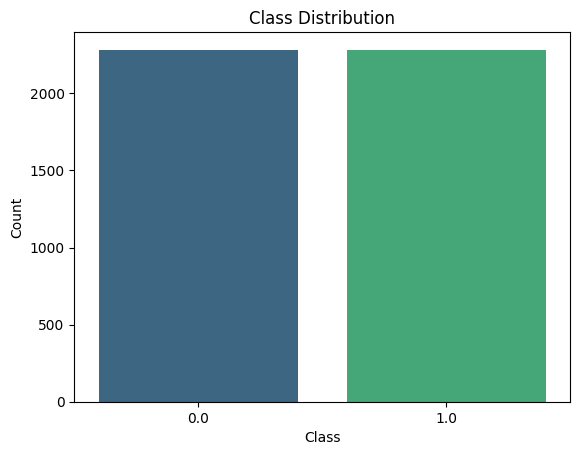

In [5]:
import math
import pandas as pd
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (LayerNormalization, Dropout, Add, Dense,
                                     GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape,
                                     Permute, Activation, Lambda, Conv2D, Concatenate, multiply)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='substate', data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

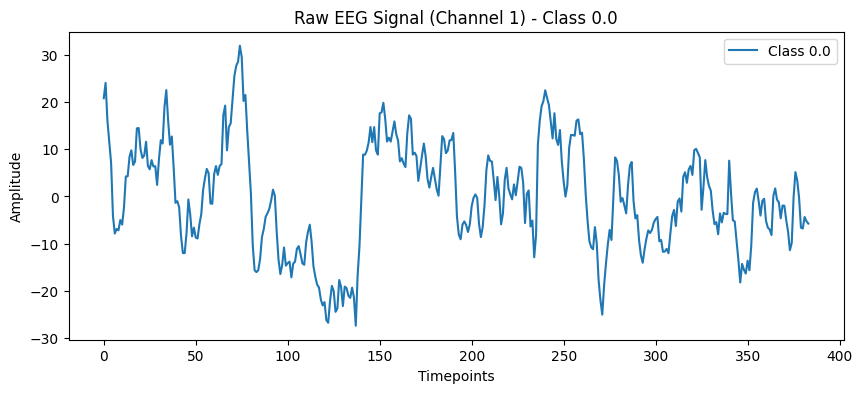

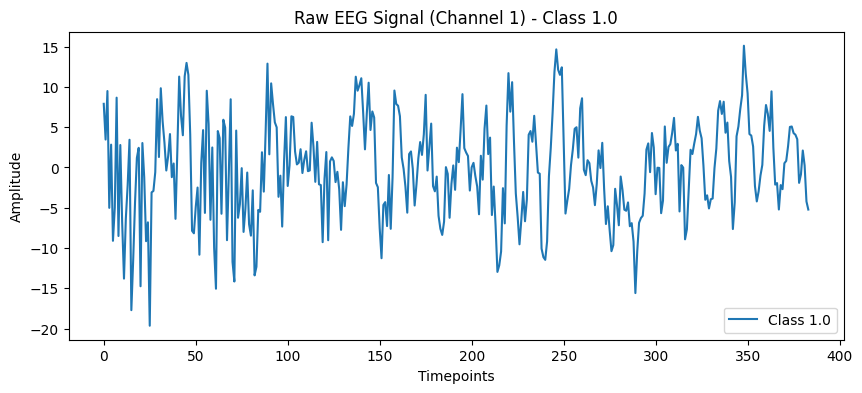

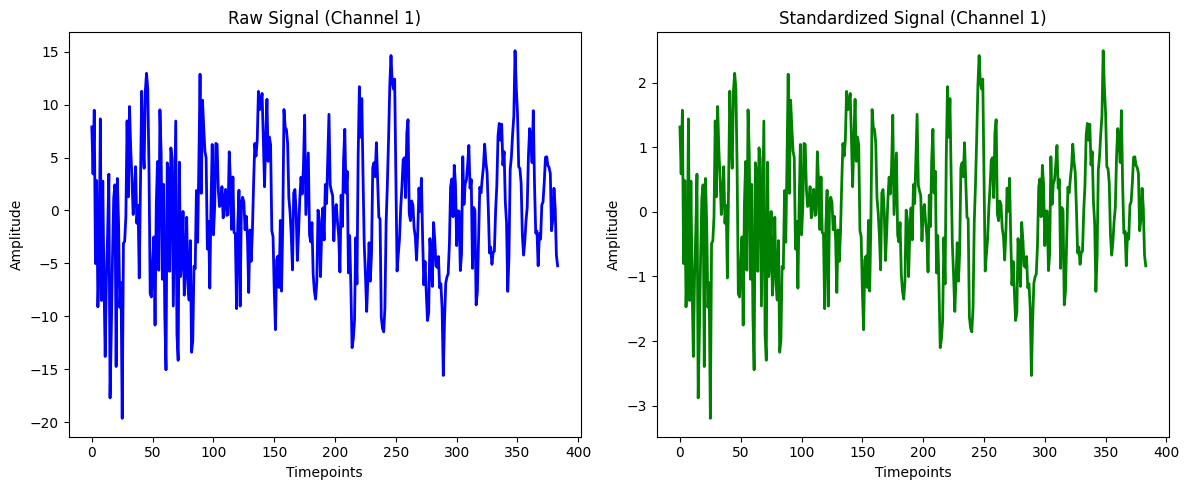

In [6]:
X = df.drop(columns=['subindex', 'substate']).values  
y = df['substate'].values  
X = X.reshape(X.shape[0], 17, 384)
X, y = shuffle(X, y, random_state=42)

# Plot raw EEG signal for Channel 1 for one sample from each class
unique_classes = np.unique(y)
for label in unique_classes:
    idx = np.where(y == label)[0][0]
    sample = X[idx, 0, :]  # Extract Channel 1
    plt.figure(figsize=(10,4))
    plt.plot(sample, label=f'Class {label}')
    plt.title(f'Raw EEG Signal (Channel 1) - Class {label}')
    plt.xlabel('Timepoints')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot raw vs standardized signal for a sample channel (Channel 1)
sample_idx = 0
raw_channel = X[sample_idx, 0, :]
scaler = StandardScaler()
standardized_channel = scaler.fit_transform(raw_channel.reshape(-1,1)).flatten()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(raw_channel, color='blue', linewidth=2)
plt.title("Raw Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(standardized_channel, color='green', linewidth=2)
plt.title("Standardized Signal (Channel 1)")
plt.xlabel("Timepoints")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


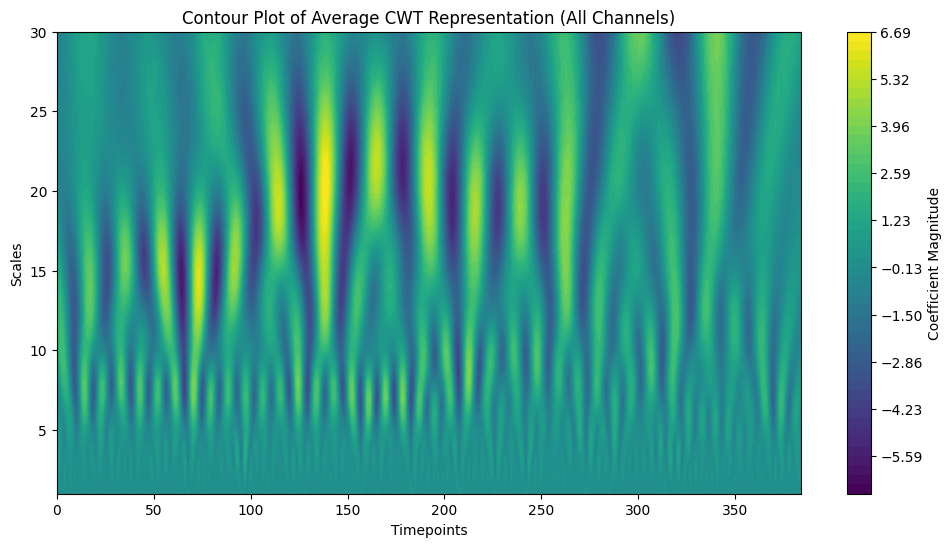

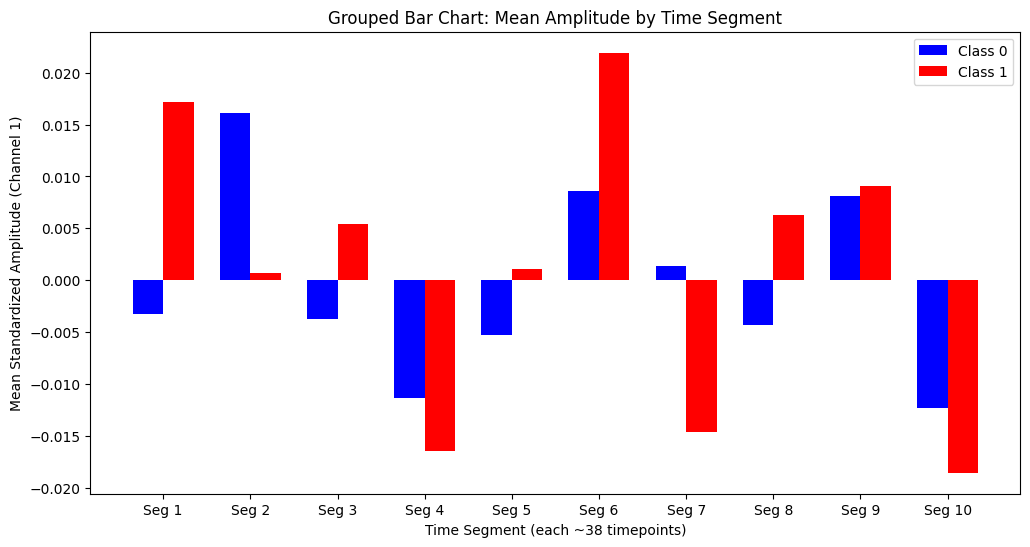

In [7]:
scales = np.arange(1, 31)
wavelet = 'morl'

# For visualization, compute the average CWT representation over a subset of samples and channels
cwt_list = []
num_samples_vis = min(10, X.shape[0])
for i in range(num_samples_vis):
    sample_cwt = []
    for ch in range(X.shape[1]):
        coeffs, _ = pywt.cwt(X[i, ch, :], scales, wavelet)
        sample_cwt.append(coeffs)
    sample_cwt = np.stack(sample_cwt, axis=-1)  # shape: (len(scales), n_timepoints, n_channels)
    cwt_list.append(np.mean(sample_cwt, axis=-1))  # average over channels
cwt_avg = np.mean(np.array(cwt_list), axis=0)

plt.figure(figsize=(12,6))
time = np.linspace(0, 384, 384)
levels = np.linspace(np.min(cwt_avg), np.max(cwt_avg), 50)
contour = plt.contourf(time, scales, cwt_avg, levels=levels, cmap='viridis')
plt.colorbar(contour, label='Coefficient Magnitude')
plt.title("Contour Plot of Average CWT Representation (All Channels)")
plt.xlabel("Timepoints")
plt.ylabel("Scales")
plt.show()

###############################################
# 4. Grouped Bar Chart: Mean Amplitude by Time Segment for Channel 1
###############################################
# Standardize the entire dataset channel-wise for visualization
X_std = np.copy(X)
for ch in range(X_std.shape[1]):
    scaler = StandardScaler()
    X_std[:, ch, :] = scaler.fit_transform(X_std[:, ch, :].reshape(-1,1)).reshape(X_std.shape[0], X_std.shape[2])

class0_idx = np.where(y == 0)[0]
class1_idx = np.where(y == 1)[0]

avg_class0 = np.mean(X_std[class0_idx, 0, :], axis=0)
avg_class1 = np.mean(X_std[class1_idx, 0, :], axis=0)

segments = 10
segment_length = 384 // segments
mean_class0_segments = [np.mean(avg_class0[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
mean_class1_segments = [np.mean(avg_class1[i*segment_length:(i+1)*segment_length]) for i in range(segments)]
indices = np.arange(segments)
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(indices - width/2, mean_class0_segments, width, label="Class 0", color="blue")
plt.bar(indices + width/2, mean_class1_segments, width, label="Class 1", color="red")
plt.xlabel(f"Time Segment (each ~{segment_length} timepoints)")
plt.ylabel("Mean Standardized Amplitude (Channel 1)")
plt.title("Grouped Bar Chart: Mean Amplitude by Time Segment")
plt.xticks(indices, [f"Seg {i+1}" for i in indices])
plt.legend()
plt.show()